In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from random import randint
import shutil
from sklearn.metrics.pairwise import cosine_similarity
import sys 
from tqdm import tqdm

tqdm.pandas()

In [2]:
img_path = "C:/Users/91730/Desktop/Alan K Alex/Nagasaki University internship/Proposed/data/Archive"

images = [
        
       f'C:/Users/91730/Desktop/Alan K Alex/Nagasaki University internship/Proposed/data/Archive{f}'
    
       for f in os.listdir(img_path)
       if os.path.isfile(os.path.join(img_path,f))
    
    
         ]

image_label = []
#label=[]

for f in os.listdir(img_path):
    new_path=os.path.join(img_path,f)
    for j in os.listdir(new_path):
        if os.path.isfile(os.path.join(new_path,j)):
            #label.append(f)
            image_label.append([os.path.join(new_path,j),f])
        
        


image_df = pd.DataFrame(image_label,columns=['img_path','label'])

#print(image_df)

image_df.head()

,img_path,label
0,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse
1,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse
2,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse
3,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse
4,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse


In [3]:
from collections import Counter

def mode_class(sim,n_ind):
    mx=-10**9
    for ind in n_ind:
        if(sim[ind]>mx):
            mx=sim[ind]
            ans=image_df['clust_nam'][ind]
    
    
    l=image_df['clust_nam'][n_ind]
    
    cnt=Counter(l)
    cnt=cnt.most_common(1)[0][1]
    
    #print(cnt)
    
    if(cnt>=(len(n_ind)/2)):
        ans=mode(image_df['clust_nam'][n_ind])
        return ans
    else:
        return ans
    

In [4]:
import statistics

from statistics import mode

def plot_similar(df,embedding_col,query_index,k_neighbors=5):
    
    similarities = cosine_similarity([df[embedding_col][query_index]],df[embedding_col].values.tolist())[0]
    
    
    k = k_neighbors+1
    nearest_indices = np.argpartition(similarities,-k)[-k:]
    
    nearest_indices = nearest_indices[nearest_indices != query_index]
    
    img = Image.open(df['img_path'][query_index]).convert('RGB')
    plt.imshow(img)
    plt.title(f'Query Product.\nIndex: {query_index}')
    
    fig=plt.figure(figsize=(20,4))
    plt.suptitle('Similar Products')
    
    for idx,neighbor in enumerate(nearest_indices):
        
        plt.subplot(1,len(nearest_indices),idx+1)
        img = Image.open(df['img_path'][neighbor]).convert('RGB')
        
        plt.imshow(img)
        plt.title(f'Cosine Sim: {similarities[neighbor]:.3f}')
        #plt.title('f Cluster: {}'.format(df.loc[neighbor,'cluster']))
    print(df['clust_nam'][nearest_indices])   
    
    #print("Image = ",mode(df['clust_nam'][nearest_indices]))
    print("Image = ",mode_class(similarities,nearest_indices))
    
       
        
    
    plt.tight_layout()

In [5]:
from pl_bolts.models.self_supervised import SimCLR
import torch

from torch.utils.data import Dataset,DataLoader
from torchvision import io,transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
weight_path ='https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'

simclr = SimCLR.load_from_checkpoint(weight_path,strict=False,batch_size=32)


simclr_resnet50 = simclr.encoder.to(device)

simclr_resnet50.eval();

C:\Users\91730\anaconda3\envs\semantic_similarity\lib\site-packages\pytorch_lightning\core\saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  rank_zero_warn(


In [7]:
class CCTVImageDataset(Dataset):
    
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        #Load the image
        
        img_path = self.df.loc[idx,'img_path']
        image = io.read_image(img_path,mode=io.image.ImageReadMode.RGB)/255
        
        # Apply Transformations
        
        if self.transform:
            
            image = self.transform(image)
            
        return image
    
    
transformations = transforms.Compose([transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),transforms.Resize(size=(64,64))])

emb_dataset = CCTVImageDataset(df=image_df,transform=transformations)

emb_dataloader = DataLoader(emb_dataset,batch_size=32)

In [8]:
embeddings = []

for batch in tqdm(emb_dataloader):
    
    batch=batch.to(device)
    embeddings+=simclr_resnet50(batch)[0].tolist()
    
image_df['simclr_img_embeddings'] = embeddings
image_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.28s/it]


,img_path,label,simclr_img_embeddings
0,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.21465498208999634, 0.0, 0.0, 0.0, 0.0,..."
1,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.08077701926231384, 1.6056780815124512, 0.0,..."
2,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.07224835455417633, 0.0, 0.48222294449806213..."
3,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.04365193098783493, 0.4220343232154846, 0.0,..."
4,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.2435416877269745, 0.1052970588207..."


In [9]:
X=[np.array(ele) for ele in image_df['simclr_img_embeddings'] ]

X= np.array(X)

#db.fit(X)

In [10]:
#plot_similar(df=image_df,embedding_col='simclr_img_embeddings',query_index=randint(0,len(image_df)-1)
            # ,k_neighbors=3)

In [11]:
from scipy import spatial

In [12]:
cos_d = []

for i in range(len(image_df)):
    row_d=[]
    for j in range(len(image_df)):
        dataset1=image_df['simclr_img_embeddings'][i]
        dataset2=image_df['simclr_img_embeddings'][j]
        val = 1 - spatial.distance.cosine(dataset1, dataset2)
        row_d.append(val)
    
    cos_d.append(row_d)
    
cos_d

[[1,
  0.7579342999609087,
  0.30457490849275504,
  0.28135114157795993,
  0.24578757845960497,
  0.7388380823700104,
  0.26274748409477167,
  0.18507876640174636,
  0.28282165142837856,
  0.17642441766967387,
  0.20278796626458206,
  0.19423651201828906,
  0.25286894293658935,
  0.39956086909830846,
  0.18773296669283313,
  0.23938884755665824,
  0.32675590433790047,
  0.26178180783880456,
  0.16509345026317312,
  0.32464458339160607,
  0.22152460105340344,
  0.2774554461187242,
  0.25201388935479385,
  0.26877683812214725,
  0.2624905711238028,
  0.2503726603119547,
  0.1837781026617339,
  0.1852136211378267,
  0.1950833153034055,
  0.19349857780953927,
  0.30827736699284847,
  0.3078332320497228,
  0.43686999007081684,
  0.4523503491903901,
  0.4028339940017267,
  0.3923524219275083,
  0.27031672630108905,
  0.4104655308485221,
  0.4277703444729495,
  0.2766834778222449],
 [0.7579342999609087,
  1,
  0.3787954710172541,
  0.31702390613165377,
  0.3334636589114305,
  0.73071554942137

## Clustering

In [13]:
import numpy as np
from sklearn.cluster import SpectralClustering

mat = np.array(cos_d)
cluster_pred = SpectralClustering(n_clusters=7,affinity="precomputed",random_state=42).fit_predict(mat)

In [14]:
cluster_pred

array([0, 0, 6, 6, 6, 0, 6, 3, 2, 4, 4, 2, 2, 2, 2, 6, 3, 1, 4, 1, 1, 1,
       4, 3, 4, 6, 1, 5, 5, 1, 1, 6, 2, 2, 2, 3, 3, 3, 3, 3])

In [15]:
image_df['cluster']=cluster_pred

In [16]:
def plot(val):
    
    cnt = 1
    
    for i in range(len(image_df)):
        if(image_df['cluster'][i]==val and cnt<=8):
            
            plt.subplot(1,9,cnt+1)
            cnt=cnt+1
            img = Image.open(image_df['img_path'][i],).convert('RGB')
            
        
            plt.rcParams["figure.figsize"] = (25,5)
            plt.imshow(img)
            #plt.title(f'Cosine Sim: {similarities[neighbor]:.3f}')
            #plt.title('f Cluster: {}'.format(df.loc[neighbor,'cluster']))


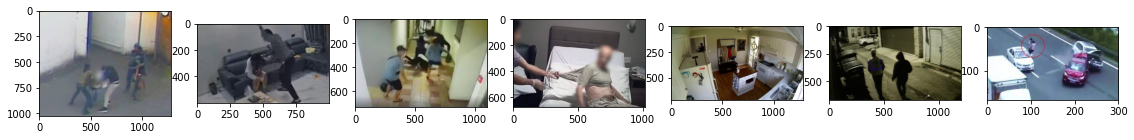

In [47]:
plot(6)

In [18]:
def assign_names():
    
    #image_df['clust_nam']=" "
    
    for i in range(len(image_df)):
        if(image_df['cluster'][i]==0 or image_df['cluster'][i]==6):
            image_df.loc[i,'clust_nam']="Abuse"
        elif(image_df['cluster'][i]==1):
            image_df.loc[i,'clust_nam']="Normal"
        
        elif(image_df['cluster'][i]==2):
            image_df.loc[i,'clust_nam']="Accident"
        
        elif(image_df['cluster'][i]==3):
            image_df.loc[i,'clust_nam']="Burglary"
            
        elif(image_df['cluster'][i]==4):
            image_df.loc[i,'clust_nam']="Night"
            
        elif(image_df['cluster'][i]==5):
            image_df.loc[i,'clust_nam']="Crowd"
            

In [19]:
assign_names()

In [20]:
image_df.head()

,img_path,label,simclr_img_embeddings,cluster,clust_nam
0,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.21465498208999634, 0.0, 0.0, 0.0, 0.0,...",0,Abuse
1,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.08077701926231384, 1.6056780815124512, 0.0,...",0,Abuse
2,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.07224835455417633, 0.0, 0.48222294449806213...",6,Abuse
3,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.04365193098783493, 0.4220343232154846, 0.0,...",6,Abuse
4,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.2435416877269745, 0.1052970588207...",6,Abuse


38    Burglary
37    Burglary
39    Burglary
Name: clust_nam, dtype: object
Image =  Burglary


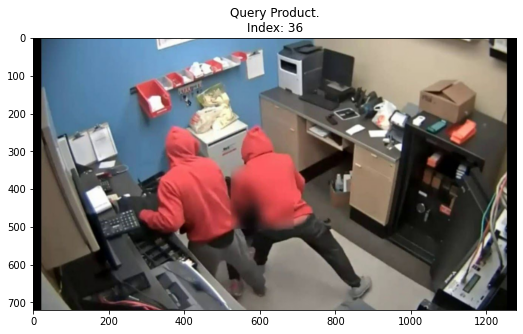

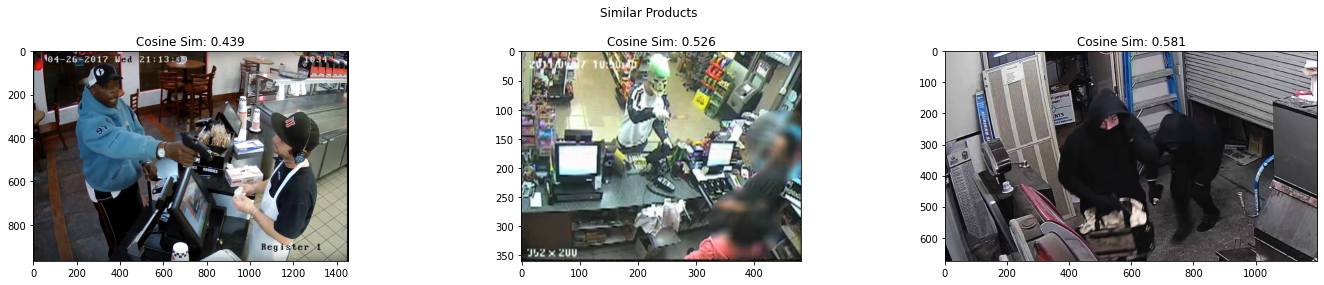

In [43]:
plot_similar(df=image_df,embedding_col='simclr_img_embeddings',query_index=randint(0,len(image_df)-1)
             ,k_neighbors=3)


In [22]:
image_df["label2"]="Normal"

In [23]:
image_df.loc[image_df['label'] != "Normal",'label2']="Anomaly"

In [24]:
image_df.head()

,img_path,label,simclr_img_embeddings,cluster,clust_nam,label2
0,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.21465498208999634, 0.0, 0.0, 0.0, 0.0,...",0,Abuse,Anomaly
1,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.08077701926231384, 1.6056780815124512, 0.0,...",0,Abuse,Anomaly
2,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.07224835455417633, 0.0, 0.48222294449806213...",6,Abuse,Anomaly
3,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.04365193098783493, 0.4220343232154846, 0.0,...",6,Abuse,Anomaly
4,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.2435416877269745, 0.1052970588207...",6,Abuse,Anomaly


In [25]:
image_df["clust_bin_label"]="Normal"

In [26]:
image_df.loc[image_df['clust_nam'] != "Normal",'clust_bin_label']="Anomaly"

In [27]:
image_df.head(20)

,img_path,label,simclr_img_embeddings,cluster,clust_nam,label2,clust_bin_label
0,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.21465498208999634, 0.0, 0.0, 0.0, 0.0,...",0,Abuse,Anomaly,Anomaly
1,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.08077701926231384, 1.6056780815124512, 0.0,...",0,Abuse,Anomaly,Anomaly
2,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.07224835455417633, 0.0, 0.48222294449806213...",6,Abuse,Anomaly,Anomaly
3,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.04365193098783493, 0.4220343232154846, 0.0,...",6,Abuse,Anomaly,Anomaly
4,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.2435416877269745, 0.1052970588207...",6,Abuse,Anomaly,Anomaly
5,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.04768519103527069, 0.5717107653617859, 0.09...",0,Abuse,Anomaly,Anomaly
6,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.017230376601219177, 0.0, 0.0, 0.0...",6,Abuse,Anomaly,Anomaly
7,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Abuse,"[0.0, 0.0, 0.0, 0.04753265529870987, 0.2865648...",3,Burglary,Anomaly,Anomaly
8,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Explosion,"[0.0, 0.1599069982767105, 0.0251874178647995, ...",2,Accident,Anomaly,Anomaly
9,C:/Users/91730/Desktop/Alan K Alex/Nagasaki Un...,Explosion,"[0.0, 0.9771378040313721, 0.0, 0.0, 0.0, 0.160...",4,Night,Anomaly,Anomaly


## Metrics

In [28]:
import seaborn as sns


<AxesSubplot:>

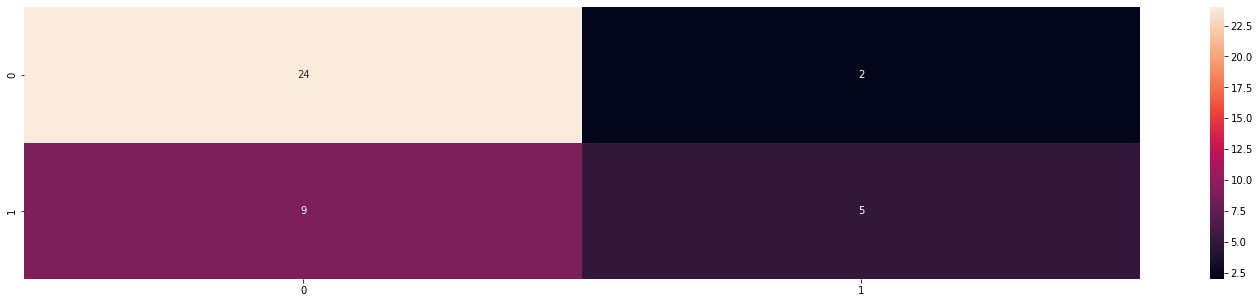

In [29]:
from sklearn.metrics import confusion_matrix

lab=image_df["label2"]
cnam=image_df["clust_bin_label"]

cf_matrix=confusion_matrix(lab,cnam)
sns.heatmap(cf_matrix, annot=True)

Text(0.5, 1.0, 'Confusion Matrix')

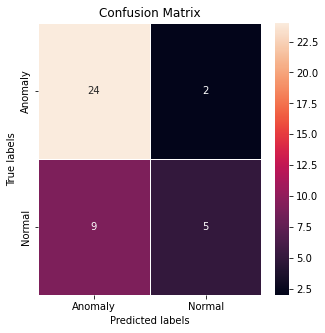

In [30]:
cf_matrix = pd.crosstab(image_df["label2"],image_df["clust_bin_label"])
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [31]:
print(len(image_df))

40


In [32]:
from sklearn.metrics import accuracy_score

In [33]:
acc = accuracy_score(lab,cnam,normalize=True)

print(acc)

0.725


In [34]:
acc = accuracy_score(lab,cnam,normalize=False)

print(acc)

29


In [35]:
lab_bin = []

clust_bin=[]

for i in range(len(image_df)):
    if(image_df["label2"][i]=="Anomaly"):
        lab_bin.append(1)
    else:
        lab_bin.append(0)
    if(image_df["clust_bin_label"][i]=="Anomaly"):
        clust_bin.append(1)
    else:
        clust_bin.append(0)
        
    
lab_bin = np.array(lab_bin)

clust_bin = np.array(clust_bin)

In [36]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(lab_bin,clust_bin)

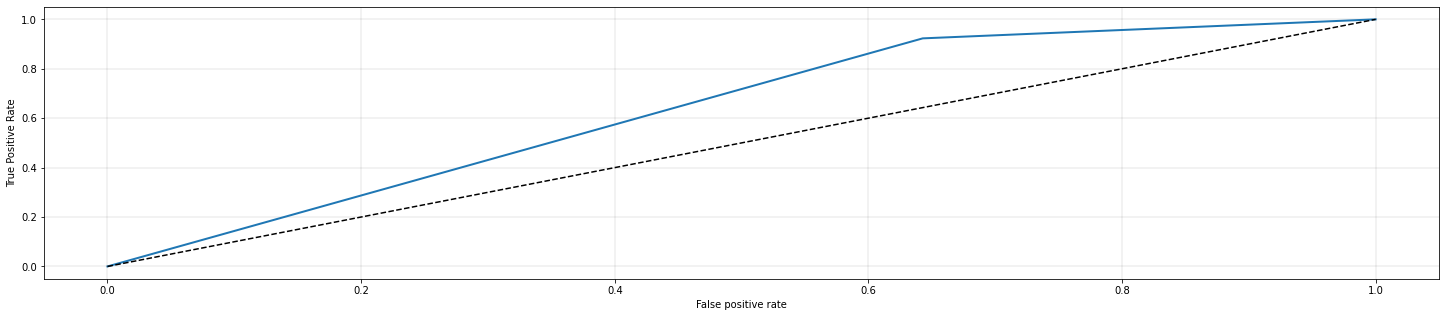

In [37]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.grid(color='black', linestyle='-', linewidth=0.1)
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(lab_bin,clust_bin)

0.6401098901098901

In [44]:
from sklearn.metrics import precision_score , recall_score

In [45]:
precision_score(lab_bin,clust_bin)

0.7272727272727273

In [46]:
recall_score(lab_bin,clust_bin)

0.9230769230769231